Keras: Training and running the model

#Connect to Python 3.10 - Pytorch and Tensorflow kernel

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

import matplotlib.pyplot as plt

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

2026-02-08 15:35:33.352015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770564933.371373   10691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770564933.377449   10691 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770564933.392241   10691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770564933.392256   10691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770564933.392258   10691 computation_placer.cc:177] computation placer alr

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
# Make a File_Helper for saving and loading files.

save_files = False

# Define File_Helper class locally to avoid importing it from a separate file, which can cause issues in Jupyter notebooks.
class File_Helper:

	"""
	These routines let us conveniently save and load input data, such
	as text and image files, as well as save and load Keras model files
	and weight files.  When we save a file, the corresponding directory 
	is created if necessary. 
	
	When we make the object, we can optionally set the one argument really_save_files
	to True or False, depending on whether or not we want save_xx() calls to really
	write files. It's time-saving to set this to False when debugging because writing
	files can take a while. The default value is True.
	
	Here's a typical way to import this package from a file in a folder two levels down
	(adapted from https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
	
	# find the absolute path to the parent folder and add that to Python's search list
	import os, sys, inspect
	current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
	sys.path.insert(0, os.path.dirname(current_dir)) # path to grandparent dir
	# Now that we can find the folder, import the package and instantiate a File_Helper object
	from Python_Utilities import File_Helper
	file_helper = File_Helper(True)  
	"""
	
	def __init__(self, really_save_files=True):
		self.really_save_files = really_save_files
		self.saved_output_dir = 'saved_output'
		self.input_data_dir = 'input_data'
		self.saved_models_dir = 'saved_models'
		self.saved_weights_dir = 'saved_weights'

	def get_input_file_path(self, filename):
		"""Get the local path relative to the calling file's location to the input file"""
		return self.input_data_dir + '/' + filename
	
	def check_for_directory(self, directory, create_if_needed=True):
		"""See if the directory exists. Optionally, create it."""
		path_exists = os.path.exists(directory)
		if path_exists:
			if not os.path.isdir(directory):
				raise Exception('Found '+directory+' but it is a file, not a directory')
				return False
			return True
		if create_if_needed:
			os.makedirs(directory)
		return path_exists

	def save_figure(self, filename):
		"""Save the figure. Call this just before plt.show()."""
		if self.really_save_files and (filename != None):
			self.check_for_directory(self.saved_output_dir)
			plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

	def load_model_weights(self, model, weights_filename):
		"""If the weights file exists, load from it and return True, else return False."""
		fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model.load_weights(fullpath)
				return True
		return False

	def save_model_weights(self, model, weights_filename):
		"""Save the weights file in the saved weights directory."""
		if self.really_save_files and (weights_filename != None):
			self.check_for_directory(self.saved_weights_dir)
			fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
			model.save_weights(fullpath)

	def load_model(self, model_filename):
		"""If the model file exists, load from it and return the model, else return None."""
		fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model = load_model(fullpath)
				return model
		return None

	def save_model(self, model, model_filename):
		"""Save the model file in the saved models directory."""
		if self.really_save_files and (model_filename != None):
			self.check_for_directory(self.saved_models_dir)
			fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
			model.save(fullpath)

	def get_saved_output_dir(self):
		"""Get the name of the directory where we save matplotlib output PNG files."""
		return self.saved_output_dir
	
	def get_input_data_dir(self):
		"""Get the name of the directory where we look for input files."""
		return self.input_data_dir
	
	def get_saved_weights_dir(self):
		"""Get the name of the directory where we read and write Keras weight files."""
		return self.saved_weights_dir
	
	def get_saved_models_dir(self):
		"""Get the name of the directory where we read and write Keras model files."""
		return self.saved_models_dir

file_helper = File_Helper(save_files)

In [5]:
random_seed = 42
np.random.seed(random_seed)

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test 
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_one_hidden_layer_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

# make the model
one_hidden_layer_model = make_one_hidden_layer_model()

# call fit() to train the model, and save the history
one_hidden_layer_history = one_hidden_layer_model.fit(X_train, y_train, 
    validation_split=0.25, epochs=3, batch_size=256, verbose=2)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770565061.606004   10691 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 722 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


Epoch 1/3


I0000 00:00:1770565063.171623   11010 service.cc:152] XLA service 0x71ff10006f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770565063.171651   11010 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2026-02-08 15:37:43.349921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770565063.683841   11010 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1770565065.042415   11010 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 - 4s - 24ms/step - accuracy: 0.9041 - loss: 0.3478 - val_accuracy: 0.9475 - val_loss: 0.1861
Epoch 2/3
176/176 - 0s - 3ms/step - accuracy: 0.9587 - loss: 0.1436 - val_accuracy: 0.9595 - val_loss: 0.1373
Epoch 3/3
176/176 - 0s - 2ms/step - accuracy: 0.9731 - loss: 0.0946 - val_accuracy: 0.9656 - val_loss: 0.1171


In [8]:
# Try it again with 20 epochs. We'll re-build the
# model so we're starting with a fresh slate. We'll
# also re-seed the random number generator for repeatability.

np.random.seed(random_seed)

# make the model
one_hidden_layer_model = make_one_hidden_layer_model()

weights_filename = "NB4-one-hidden-layer-model"
if not file_helper.load_model_weights(one_hidden_layer_model, weights_filename):
    one_hidden_layer_model.fit(X_train, y_train, 
                               validation_split=0.25, 
                               epochs=20, batch_size=256, verbose=2)
    file_helper.save_model_weights(one_hidden_layer_model, weights_filename)

Epoch 1/20
176/176 - 2s - 14ms/step - accuracy: 0.9029 - loss: 0.3475 - val_accuracy: 0.9505 - val_loss: 0.1779
Epoch 2/20
176/176 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.1419 - val_accuracy: 0.9604 - val_loss: 0.1345
Epoch 3/20
176/176 - 0s - 3ms/step - accuracy: 0.9728 - loss: 0.0937 - val_accuracy: 0.9683 - val_loss: 0.1105
Epoch 4/20
176/176 - 0s - 3ms/step - accuracy: 0.9816 - loss: 0.0662 - val_accuracy: 0.9707 - val_loss: 0.0993
Epoch 5/20
176/176 - 0s - 3ms/step - accuracy: 0.9856 - loss: 0.0501 - val_accuracy: 0.9734 - val_loss: 0.0871
Epoch 6/20
176/176 - 0s - 3ms/step - accuracy: 0.9902 - loss: 0.0377 - val_accuracy: 0.9747 - val_loss: 0.0836
Epoch 7/20
176/176 - 0s - 3ms/step - accuracy: 0.9930 - loss: 0.0287 - val_accuracy: 0.9757 - val_loss: 0.0802
Epoch 8/20
176/176 - 0s - 3ms/step - accuracy: 0.9950 - loss: 0.0216 - val_accuracy: 0.9771 - val_loss: 0.0782
Epoch 9/20
176/176 - 0s - 3ms/step - accuracy: 0.9965 - loss: 0.0167 - val_accuracy: 0.9745 - val_loss: 0.0861


In [9]:
# build the error grid. each [y][x] is a list of all test images
# with label y, but were mis-categorized as x
predictions = np.argmax(one_hidden_layer_model.predict(X_test), axis=-1)

error_grid = [[[] for x in range(10)] for y in range(10)] 
matchList = predictions == original_y_test
errorCount = 0
for i in range(matchList.size):
    if matchList[i] != True:
        error_grid[original_y_test[i]][predictions[i]].append(i)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [10]:
# how many did we get right?
pred_right = np.sum(matchList)
pred_wrong = len(original_y_test)-pred_right
print("Correct predictions = ",pred_right," out of ",len(original_y_test))
print("Incorrect predictions = ",pred_wrong)

Correct predictions =  9825  out of  10000
Incorrect predictions =  175


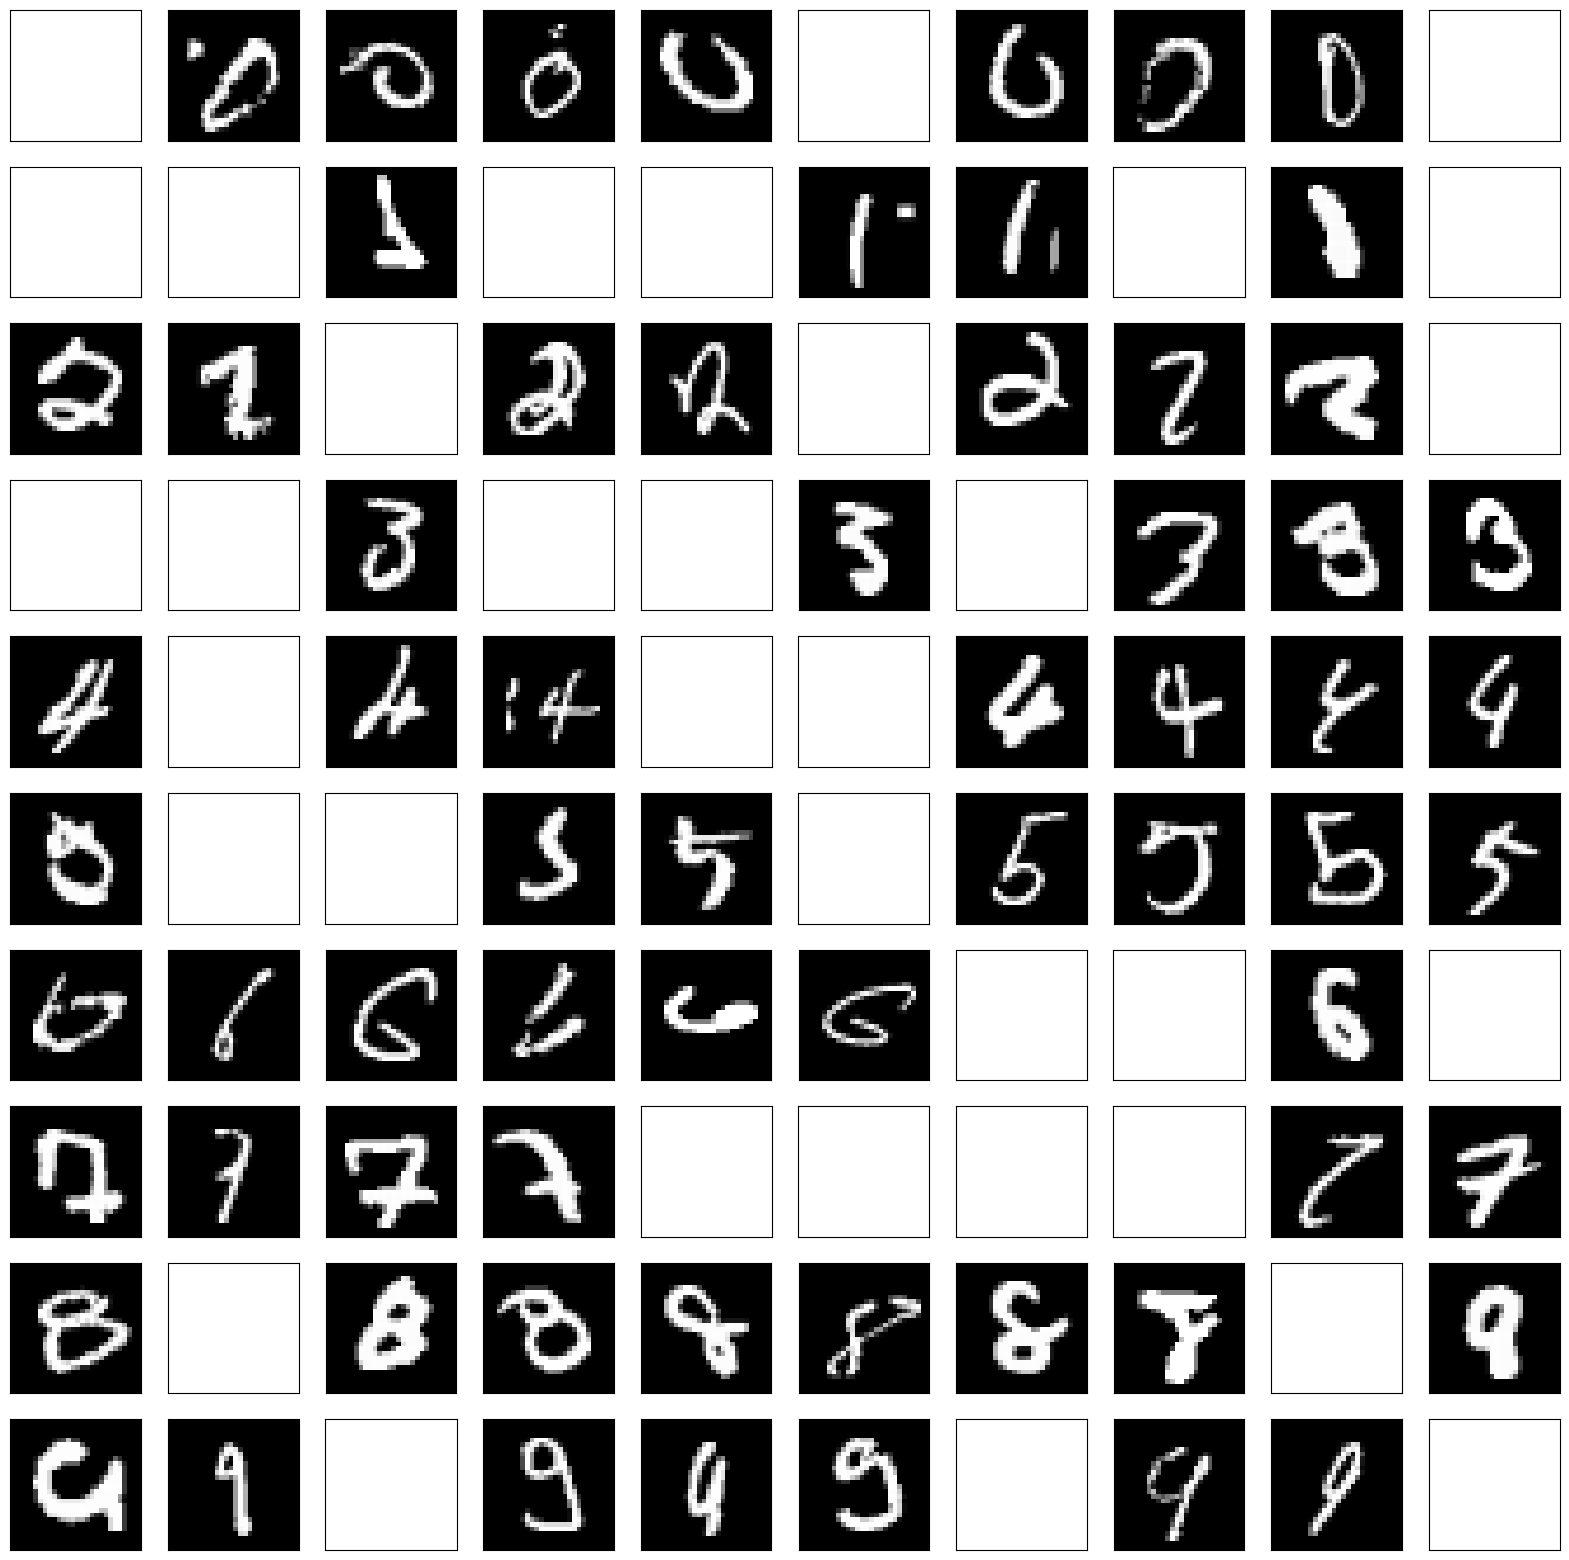

In [11]:
# show the first image in each cell of the error grid
plt.figure(figsize=(20,20))
for y in range(10):
    for x in range(10):
        plt.subplot(10, 10, 1 + (y*10) + x)
        if error_grid[y][x]:
            list_index = error_grid[y][x][0]
            #print("list_index = ",list_index)
            img = X_test[list_index].reshape(28, 28)
            plt.imshow(img, cmap=plt.get_cmap('gray'))
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
file_helper.save_figure('Prediction-error-examples')
plt.show()

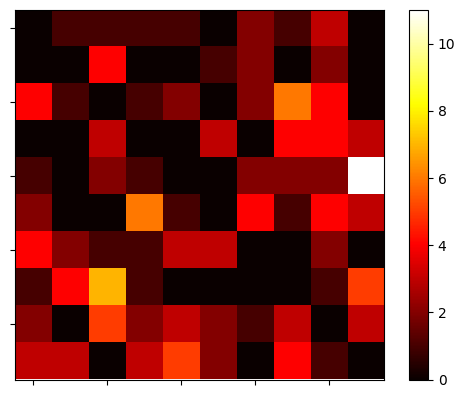

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# show a heat map of the length of each error list
gridsize = [[len(error_grid[y][x]) for x in range(10)] for y in range(10)]
fig, ax = plt.subplots()
im = plt.imshow(gridsize, cmap='hot', interpolation='nearest')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.25)
fig.colorbar(im, cax=cax, orientation='vertical')
file_helper.save_figure('Prediction-error-heatmap')
plt.show()